In [4]:
import sys
sys.path.append('/home/jovyan')
import read_data
from io import StringIO

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import seaborn as sns

In [5]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_rss"}
start_time = '2024-04-22T09:15:13.908Z'
end_time = '2024-04-22T10:05:20.908Z'
out = read_data.read_data(dict_data, start_time, end_time)

In [6]:
print(len(out))

19117697


In [7]:
lines = out.split('\n')
for i in range (10):
    print(lines[i])

"time","name","value","unit","metric.attributes.case_number","metric.attributes.pipeline_id","metric.attributes.slurm_job_id","metric.attributes.step_name","metric.attributes.pipeline_name"
"2024-04-22T09:41:03.257003928Z","slurm_job_memory_total_rss","29990912.0","","Paper_cohort_0064_Pinaki_na","5","8691392","bonestrength_markov","Real1_5"
"2024-04-22T09:41:06.335608848Z","slurm_job_memory_total_rss","41865216.0","","Paper_cohort_0064_Pinaki_na","5","8691392","bonestrength_markov","Real1_5"
"2024-04-22T09:41:09.462968175Z","slurm_job_memory_total_rss","300720128.0","","Paper_cohort_0064_Pinaki_na","5","8691392","bonestrength_markov","Real1_5"
"2024-04-22T09:41:12.576872552Z","slurm_job_memory_total_rss","1106329600.0","","Paper_cohort_0064_Pinaki_na","5","8691392","bonestrength_markov","Real1_5"
"2024-04-22T09:41:15.712149579Z","slurm_job_memory_total_rss","1472827392.0","","Paper_cohort_0064_Pinaki_na","5","8691392","bonestrength_markov","Real1_5"
"2024-04-22T09:41:18.814198796Z","s

In [8]:
def read_data_to_df(dict_data, start_time, end_time):
    csv_data = read_data.read_data(dict_data, start_time, end_time)

    df = pd.read_csv(StringIO(csv_data))
    df['time'] = pd.to_datetime(df['time'])

    return df

In [9]:
def plot_agregation(df, xlabel, ylabel, ax):
    df['time'] = df['time'].dt.floor('3s')
    df = df.groupby(['time']).sum().reset_index()
    
    plt.sca(ax)
    sns.lineplot(ax=ax, data=df, x="time", y="value")


    min_time = df['time'].min()
    max_time = df['time'].max()
    selected_times = pd.date_range(start=min_time, end=max_time, periods=15)
    ax.set_xticks(selected_times)
    
    date_form = DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(date_form)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    
    # rotation = plt.xticks(rotation=45, ax = ax)

def plot_histogram(df, xlabel, ylabel, ax):
    
    df = df.groupby('metric.attributes.slurm_job_id')['value'].max().reset_index()
    plt.sca(ax)
    sns.histplot(df['value'], bins=10, color='skyblue', edgecolor='black')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    

In [22]:
def plot_time_layout(df, xlabel, ylabel, ax):

    plt.sca(ax)
        
    job_durations = df.groupby('metric.attributes.slurm_job_id')['time'].apply(lambda x: x.max() - x.min())
    
    
    sns.histplot(job_durations.dt.total_seconds(), bins=20, color='skyblue', edgecolor='black', ax=ax)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('Job Durations Histogram')


def plot_job_timeline(df, xlabel, ylabel, ax):
    plt.sca(ax)
    
    grouped = df.groupby('metric.attributes.slurm_job_id')

    for job, (_, group) in enumerate(grouped):
        min_time = group['time'].min()
        max_time = group['time'].max()
        plt.hlines(y=job, xmin=min_time, xmax=max_time, color='skyblue')
    
    ax.set_ylabel(ylabel)
    ax.set_title('Job Execution Timeline')
    plt.grid(True)
    date_form = DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(date_form)
    
    # if ax is None:
    #     plt.show()

In [11]:
def plot_grid_set(df, ylabel):

    g = sns.FacetGrid(df, col='metric.attributes.slurm_job_id', col_wrap=3, height=4, sharex=False, sharey=False)
    g.map_dataframe(sns.lineplot, x='time', y='value')
    
    date_format = DateFormatter("%H:%M:%S")
    for ax in g.axes.flat:
        ax.xaxis.set_major_formatter(date_format)
    for ax in g.axes.flat:
        ax.set_xticks(ax.get_xticks()[::len(ax.get_xticks())//2])
    
    for ax in g.axes.flat:
        job_id = ax.get_title().split(" = ")[-1].strip()
        # print(job_id)
        subset = df[df['metric.attributes.slurm_job_id'] == int(job_id)]
        # print("subset: ")
        # print(subset)
        # print()
        max_value = subset['value'].max()
        ax.set_ylim(0, max_value * 1.1)

    ax.set_ylabel(ylabel)
    plt.tight_layout()


def plot_grid(df, ylabel):
    unique_job_ids = df['metric.attributes.slurm_job_id'].unique()
    # print(len(unique_job_ids))
    max_length = 99
    job_id_sets = [unique_job_ids[i:i+max_length] for i in range(0, len(unique_job_ids), max_length)]

    for job_id_set in job_id_sets:
        current_df = df[df['metric.attributes.slurm_job_id'].isin(job_ids)]
        plot_grid_set(current_df, ylabel)
    

In [12]:
def plot_single_visualisation(df, func, xlabel, ylabel):
    fig, axes = plt.subplots(figsize=(16, 8))
    func(df, xlabel, ylabel, axes)
    plt.tight_layout()
    plt.show()

def plot_double_visualisation(df1, func1, xlabel1, ylabel1, df2, func2, xlabel2, ylabel2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    func1(df1, xlabel1, ylabel1, axes[0])
    func2(df2, xlabel2, ylabel2, axes[1])
    plt.tight_layout()
    plt.show()

In [13]:
start_time = '2024-06-04T08:15:13.908Z'
end_time = '2024-06-04T11:05:20.908Z'

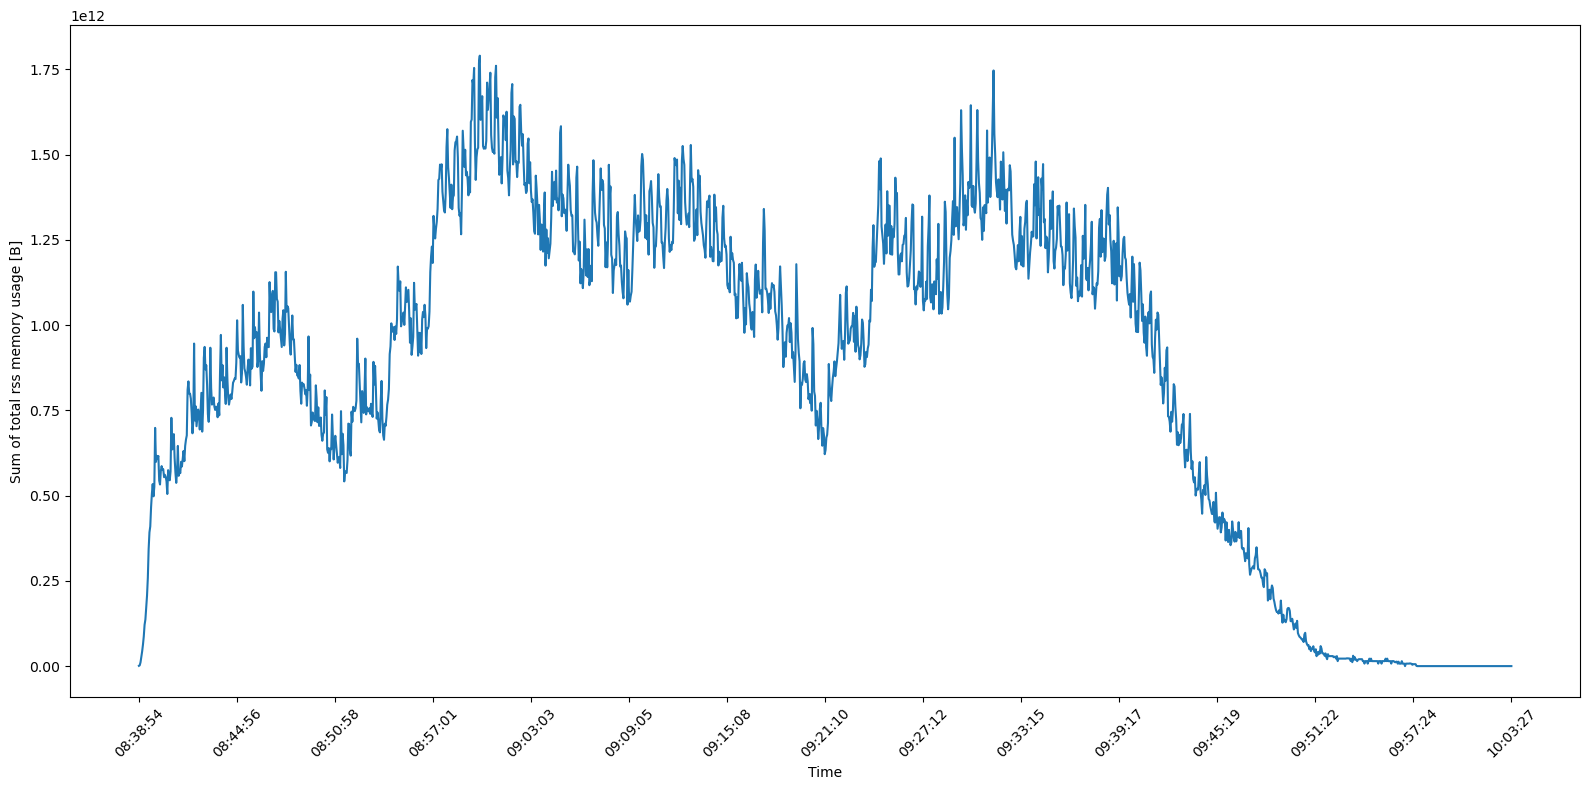

In [11]:
#example use of single visualisation
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_rss"}
df = read_data_to_df(dict_data, start_time, end_time)

plot_single_visualisation(df, plot_agregation, 'Time', 'Sum of total rss memory usage [B]')

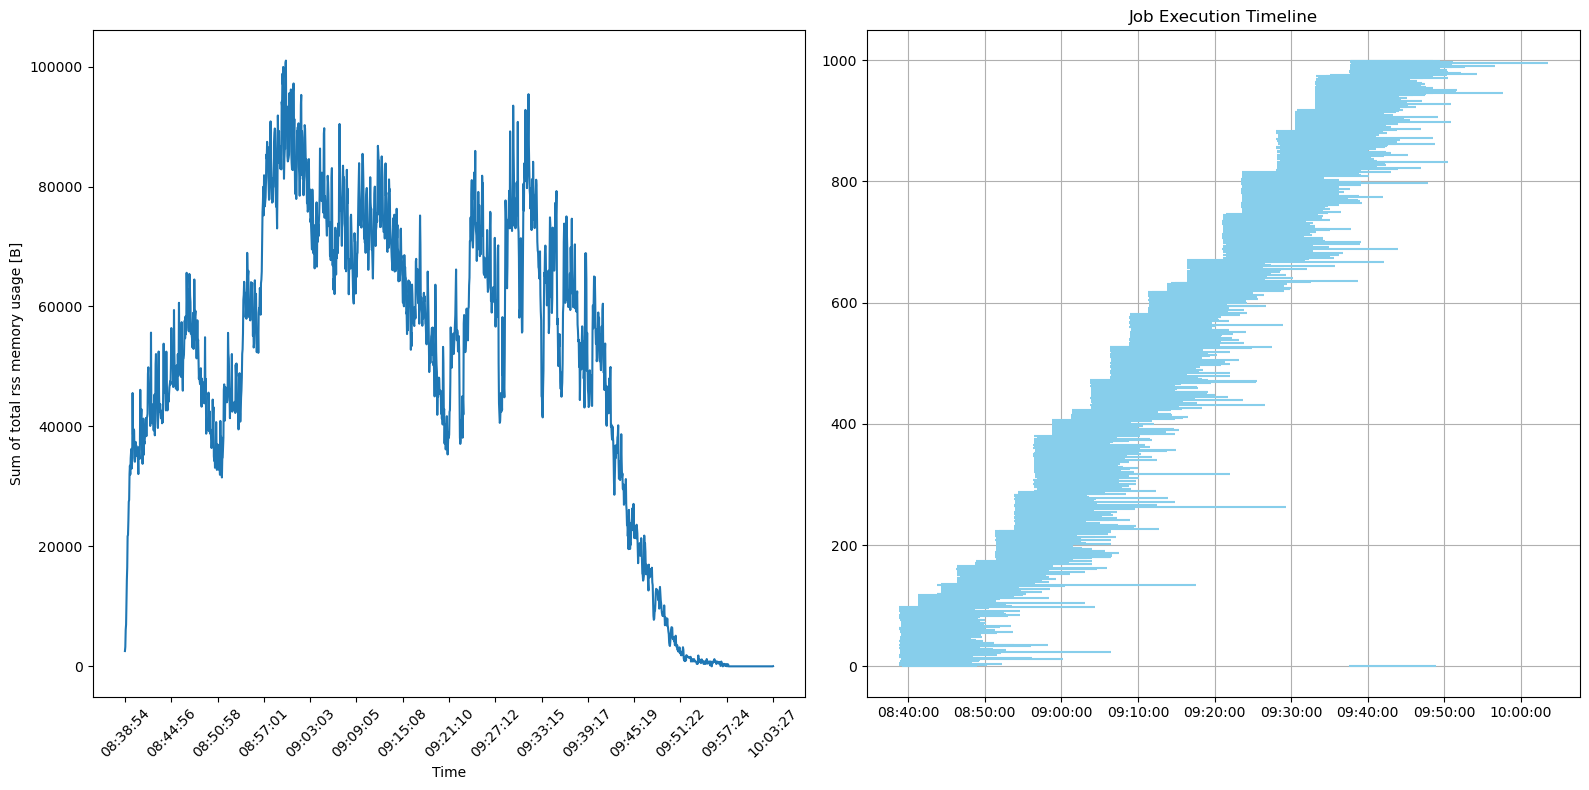

In [23]:
#example use of double visualisation
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_cpu_percentage_usage"}
df = read_data_to_df(dict_data, start_time, end_time)
                     
plot_double_visualisation(df, plot_agregation, 'Time', 'Sum of total rss memory usage [B]', df, plot_job_timeline, 'Time', '')


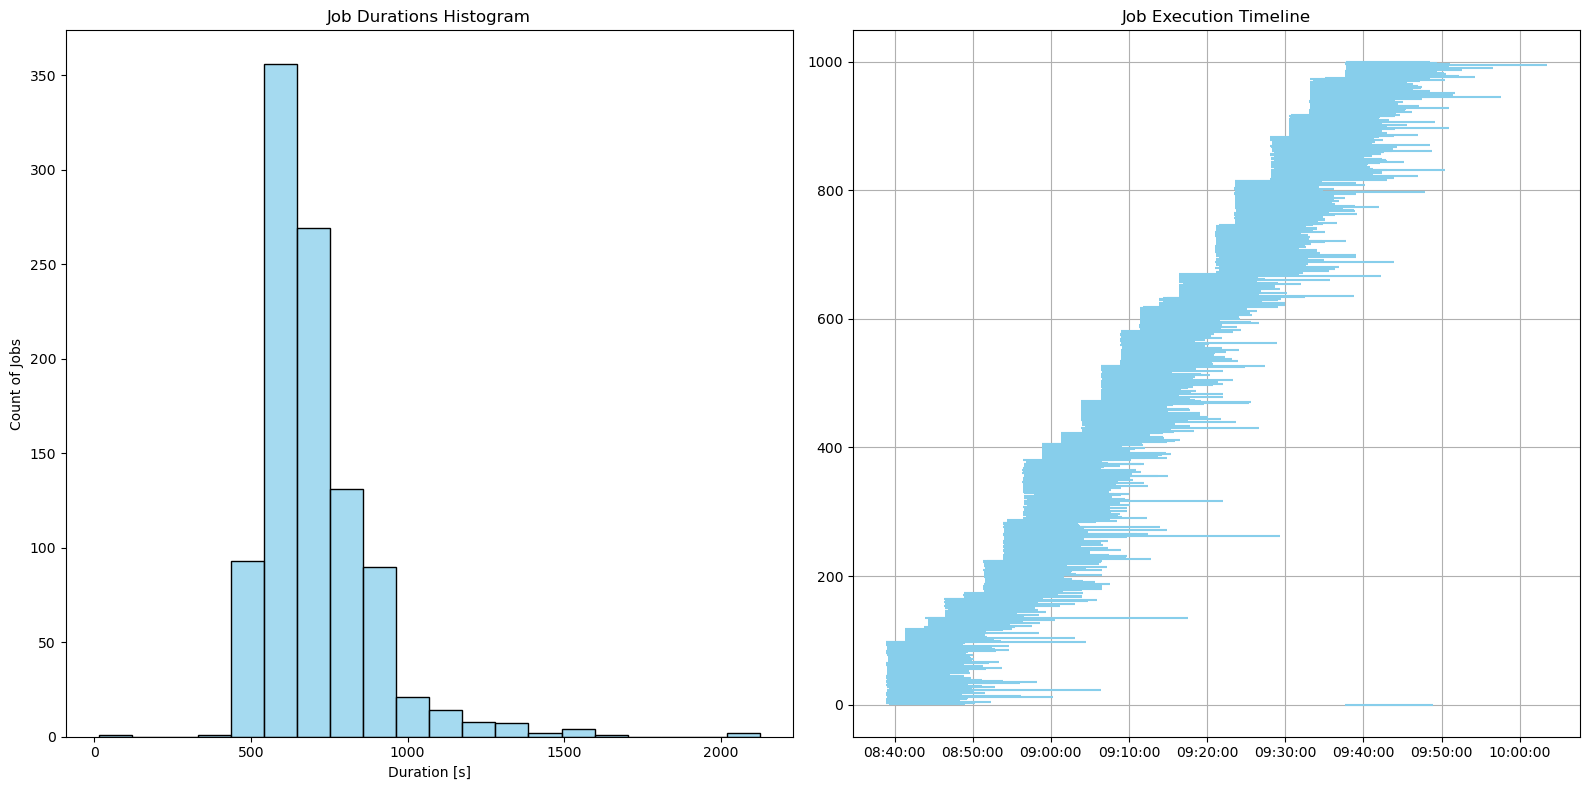

In [24]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_cpu_percentage_usage"}
df = read_data_to_df(dict_data, start_time, end_time)
                     
plot_double_visualisation(df, plot_time_layout, 'Duration [s]', 'Count of Jobs', df, plot_job_timeline, 'Time', '')


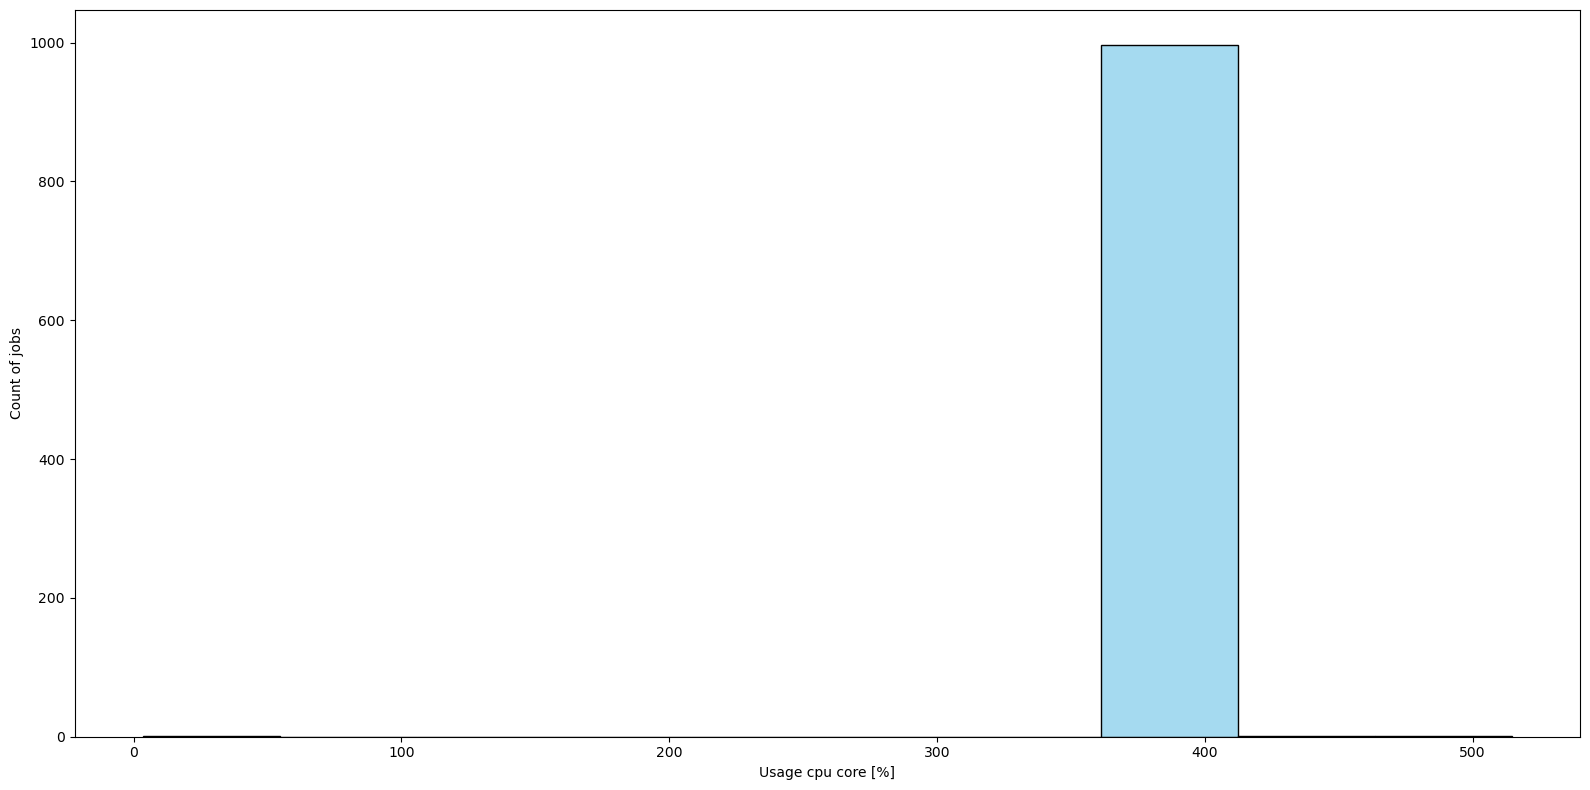

In [12]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_cpu_percentage_usage"}
df = read_data_to_df(dict_data, start_time, end_time)

plot_single_visualisation(df, plot_histogram, 'Usage cpu core [%]', 'Count of jobs')

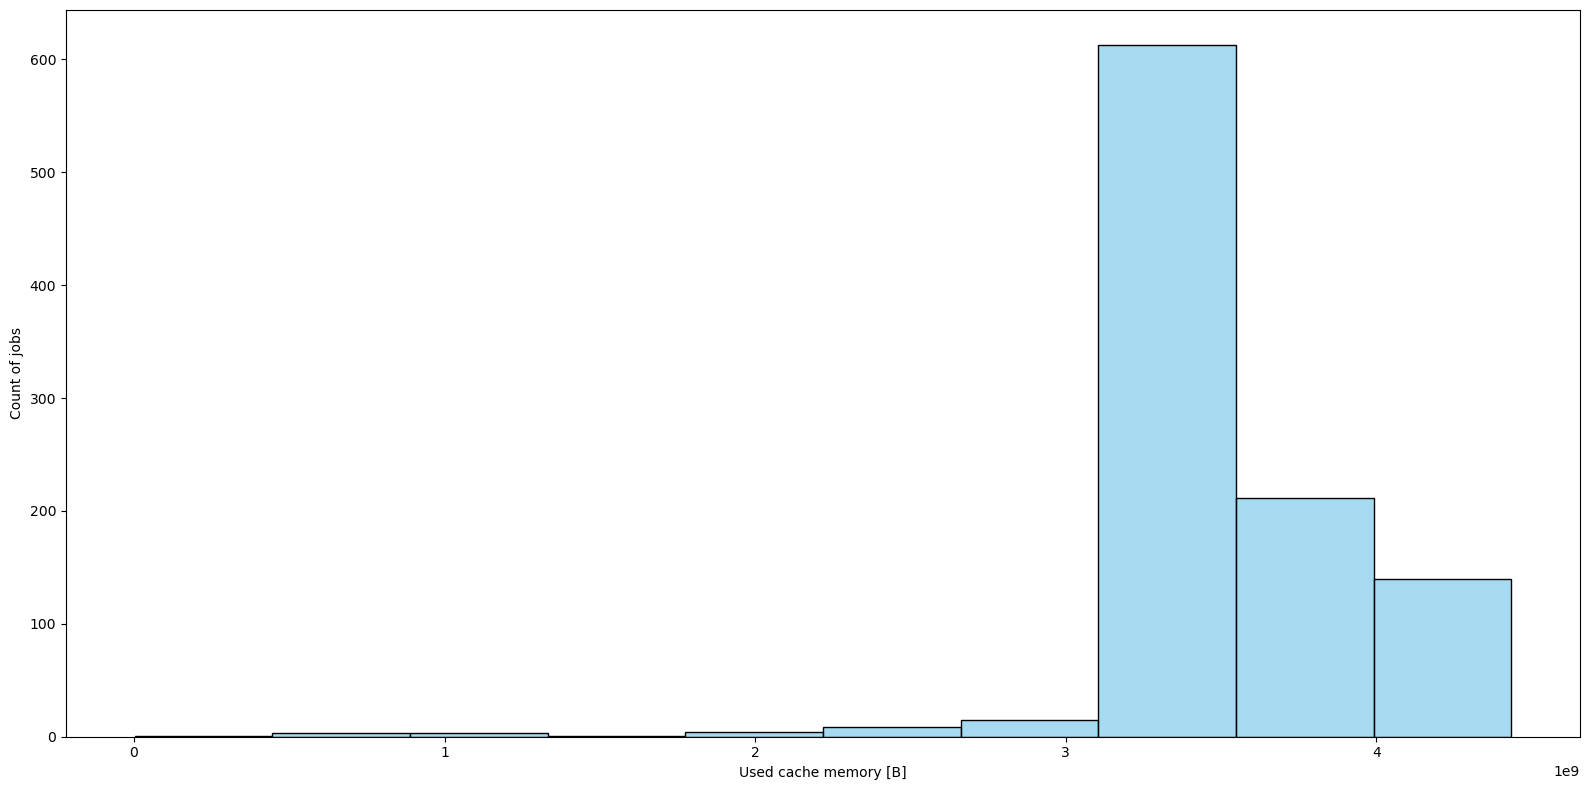

In [17]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_cpu_percentage_usage"}
df = read_data_to_df(dict_data, start_time, end_time)

plot_single_visualisation(df, plot_histogram, 'Used cache memory [B]', 'Count of jobs')

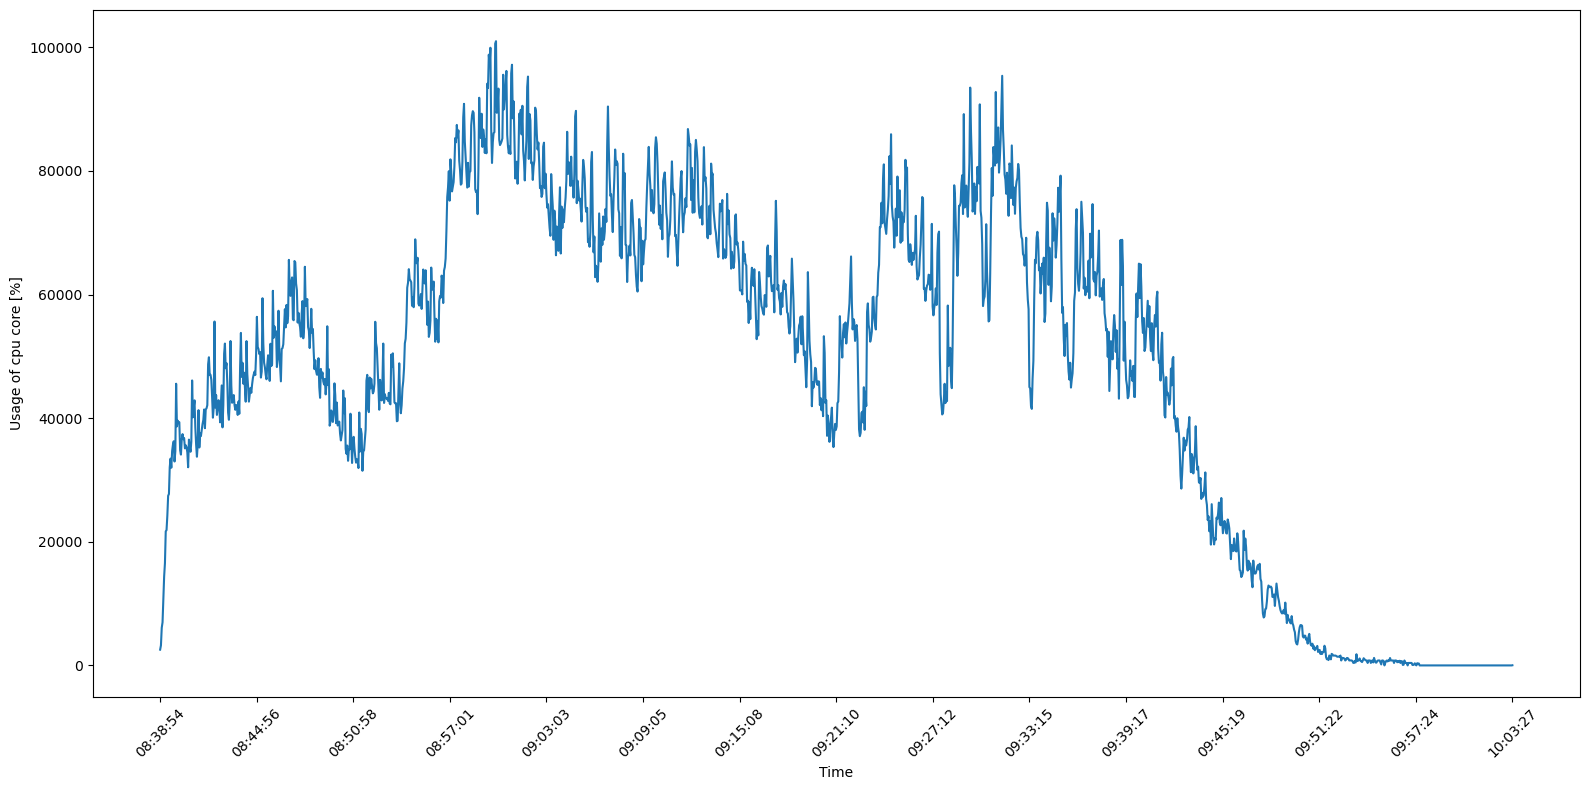

In [26]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_cpu_percentage_usage"}
df = read_data_to_df(dict_data, start_time, end_time)

plot_single_visualisation(df, plot_agregation, 'Time', 'Usage of cpu core [%]')

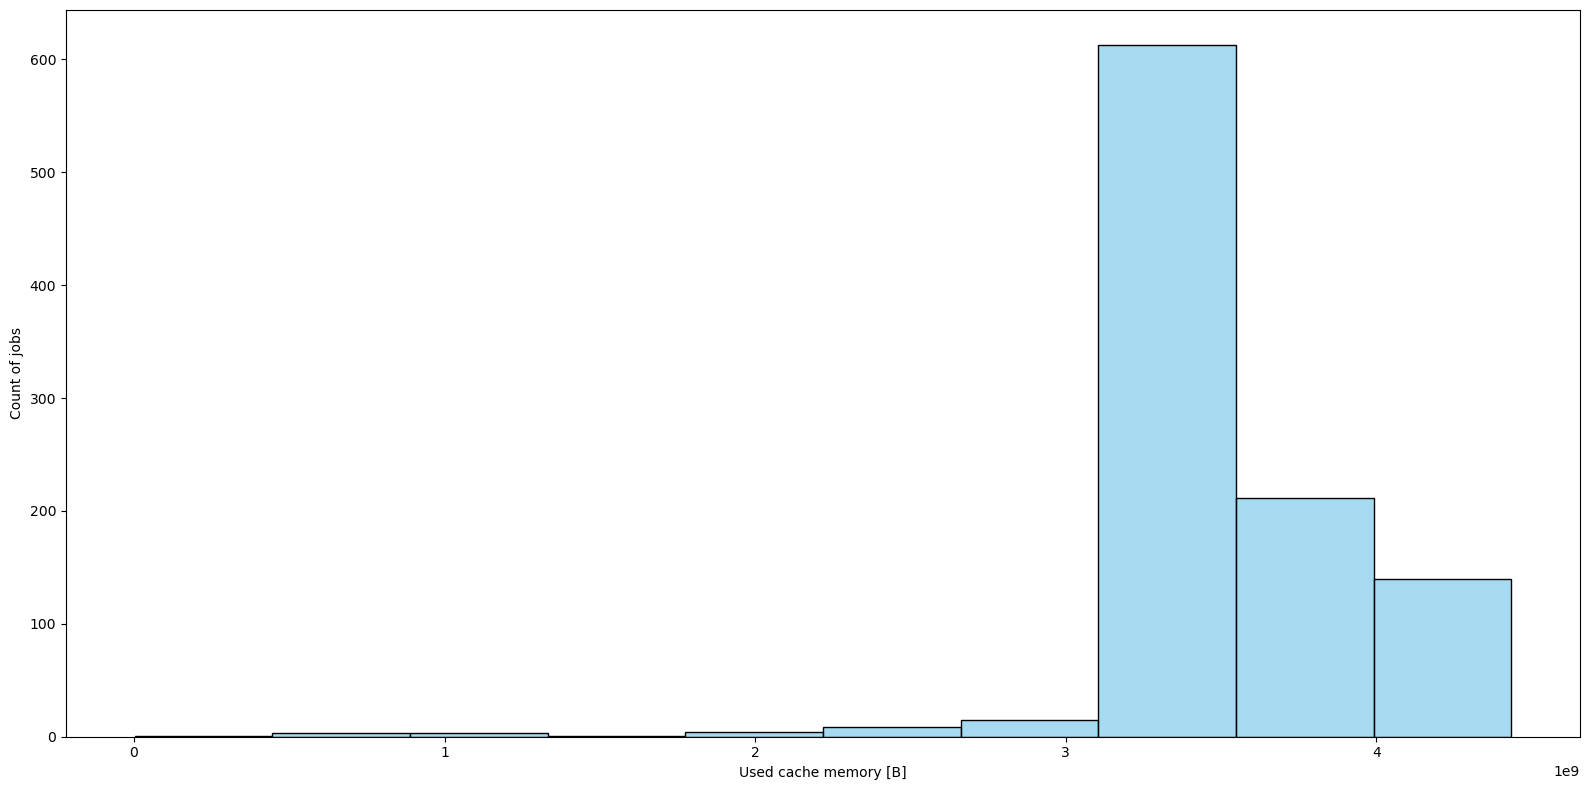

In [27]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_cache"}
df = read_data_to_df(dict_data, start_time, end_time)

plot_single_visualisation(df, plot_histogram, 'Used cache memory [B]', 'Count of jobs')